## 1.Problem Statement : Find the diffrent group of customers with their Loaylty,Multiple Purchase,more spending persons by diffrent Stategies.

- ### Strategies :  1.RFM Score and value, 2.Customer Loyalty (PlatinumGold,Silver)

- ### Dataset : Customer purchase data with details of purchased products,sales detail and another 23 columns

### Importing Customer purchasse Data for RFM Calculation

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import warnings
from pandas import ExcelWriter
from pandas import ExcelFile
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
%matplotlib inline
import seaborn as sns
file=pd.read_excel('C:/datalake/project_retail/master_dataset.xlsx', sheet_name='customer_purchase',encoding = 'unicode_escape')
file.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,2011-01-01,2011-01-05,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High


#### Making Customize dataframe for RMF calculation.

In [31]:
# selecting required columns
df=file.loc[:,['Order ID', 'Order Date','Customer ID','Sales']]

# making date format
df['date'] = pd.DatetimeIndex(df['Order Date']).date
df.dropna(subset=['Customer ID'],how='all',inplace=True)
df.head(4)

,Order ID,Order Date,Customer ID,Sales,date
0,AG-2011-2040,2011-01-01,TB-11280,408.300,2011-01-01
1,IN-2011-47883,2011-01-01,JH-15985,120.366,2011-01-01
2,HU-2011-1220,2011-01-01,AT-735,66.120,2011-01-01
3,IT-2011-3647632,2011-01-01,EM-14140,44.865,2011-01-01


- ### RFM Calculation consist of Recency,Frequecy & Monetory.

- #### Recency (R): Who have purchased recently? Number of days since last purchase (least recency)


- #### Frequency (F): Who has purchased frequently? It means the total number of purchases.(high frequency)

- #### Monetary Value(M): Who have high purchase amount? It means the total money customer spent (high monetary value)

#### Recency Calculation

In [32]:
# selecting nearest date for recency calculation 
now = dt.date(2015,1,1)
recency_df = df.groupby(['Customer ID'],as_index=False)['date'].max()
recency_df.columns = ['Customer ID','LastPurchaseDate']

# subtracting latest date(now) from purchase Date
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)
recency_df=recency_df.drop(columns=['LastPurchaseDate'])
recency_df.head(3)

,Customer ID,Recency
0,AA-10315,9
1,AA-10375,7
2,AA-10480,126


#### Frequency Calculation

In [33]:
# Calculating total no. customer purchase (Frequecy)
frequency_df = df.copy()
frequency_df.drop_duplicates(subset=['Customer ID','Order ID'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('Customer ID',as_index=False)['Order ID'].count()
frequency_df.columns = ['Customer ID','Frequency']
frequency_df.head(3)

,Customer ID,Frequency
0,AA-10315,19
1,AA-10375,23
2,AA-10480,20


#### Monetary Calculation

In [34]:
# Summing customerwisse sales for Monetary calculation
monetary_df=df.groupby('Customer ID',as_index=False)['Sales'].sum()
monetary_df.columns = ['Customer ID','Monetary']
monetary_df.head(3)

,Customer ID,Monetary
0,AA-10315,13747.41300
1,AA-10375,5884.19500
2,AA-10480,17695.58978


### Combining Recency,Frequency & Monetory dataframe into one dataframe named 'rfm'

In [35]:
# customer ID wise RFM Score in one Dataframe
rf = recency_df.merge(frequency_df,left_on='Customer ID',right_on='Customer ID')
rfm = rf.merge(monetary_df,left_on='Customer ID',right_on='Customer ID')
rfm.set_index('Customer ID',inplace=True)
rfm.head(3)

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,9,19,13747.41300
AA-10375,7,23,5884.19500
AA-10480,126,20,17695.58978


### Standardising RFM values into 1 to 4 unit values

In [36]:
# using qcut methode for bins based on sample quantiles
rfm['r_score'] = pd.qcut(rfm['Recency'], 4, ['1','2','3','4'])
rfm['f_score'] = pd.qcut(rfm['Frequency'], 4, ['4','3','2','1'])
rfm['m_score'] = pd.qcut(rfm['Monetary'], 4, ['4','3','2','1'])
rfm.head(3)

,Recency,Frequency,Monetary,r_score,f_score,m_score
Customer ID,,,,,,
AA-10315,9,19,13747.41300,1,2,1
AA-10375,7,23,5884.19500,1,2,3
AA-10480,126,20,17695.58978,4,2,1


#### Calculating RFM Score value

In [37]:
# Combining recency,frequecy,monetory as RFM_score
rfm['RFM_score'] = rfm['r_score'].astype(str)+ rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm.head(3)

,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM_score
Customer ID,,,,,,,
AA-10315,9,19,13747.41300,1,2,1,121
AA-10375,7,23,5884.19500,1,2,3,123
AA-10480,126,20,17695.58978,4,2,1,421


#### Calculating RFM Group value

In [38]:
# Numerical addition of RFM_score which is RFM_group
rfm['RFM_group'] = rfm['r_score'].astype(int)+ rfm['f_score'].astype(int) + rfm['m_score'].astype(int)
rfm.head(3)

,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM_score,RFM_group
Customer ID,,,,,,,,
AA-10315,9,19,13747.41300,1,2,1,121,4
AA-10375,7,23,5884.19500,1,2,3,123,6
AA-10480,126,20,17695.58978,4,2,1,421,7


### These are top 10 best customers...!!!

In [50]:
# finding Top ten customer
rfm[rfm['RFM_score']=='111'].sort_values('Monetary', ascending=False)

,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM_score,RFM_group,Loyalty
Customer ID,,,,,,,,,
GT-14710,9,30,34471.89028,1,1,1,111,3,Platinum
SE-20110,10,36,29532.62502,1,1,1,111,3,Platinum
ZC-21910,4,37,28472.81926,1,1,1,111,3,Platinum
SP-20920,7,28,28124.21286,1,1,1,111,3,Platinum
NF-18385,8,32,28044.35950,1,1,1,111,3,Platinum
...,...,...,...,...,...,...,...,...,...
JL-15175,7,27,13499.87246,1,1,1,111,3,Platinum
DS-13180,15,31,13447.41200,1,1,1,111,3,Platinum
EB-13975,1,32,13405.60130,1,1,1,111,3,Platinum


### Customer Classes

In [40]:
# class of customer example - Platinum, Gold and Silver.

# Platinum Customer - frequent and more revenue generator.
# Gold Customer - frequent but less revenue generator.
# Silver Customer - less frequent and less revenue generator.

levels=['Platinum','Gold','Silver']
rfm['Loyalty']=pd.qcut(rfm.RFM_group,q=3,labels=levels)
rfm.reset_index().sample(3)

,Customer ID,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM_score,RFM_group,Loyalty
43,AG-10765,29,27,9824.7795,2,1,2,212,5,Platinum
1539,TS-21655,85,24,9525.4572,3,2,2,322,7,Gold
1066,MP-17470,6,28,12928.8028,1,1,2,112,4,Platinum


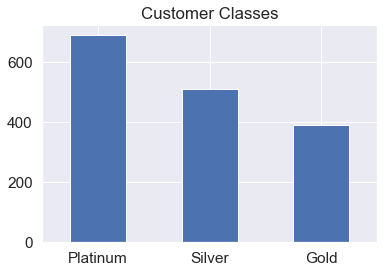

In [41]:
sns.set(font_scale=1.4)
rfm['Loyalty'].value_counts().plot(kind='bar', rot=0);
plt.title('Customer Classes');

## RFM Segments

In [3]:
# https://github.com/pavano1760/Documents/blob/master/1.retail_project/1.3.png

### 1.Loyal -Your Best Customers

Loyal(Most Loyal Customers)- 105


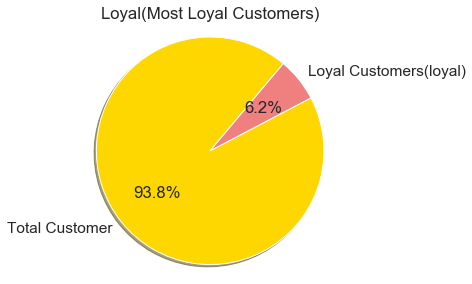

In [42]:
# RFM Code: 111
print('Loyal(Most Loyal Customers)-',len(rfm[(rfm['RFM_score']=='111')]))
labels = ['Total Customer','Loyal Customers(loyal)']
sizes = [1590,105]
fig1, ax1 = plt.subplots()
colors = ['gold', 'lightcoral']
explode = (0.1, 0, 0) 
ax1.pie(sizes,labels=labels,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=50)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Loyal(Most Loyal Customers)');

### 2.Whales - Highest Paying Customers

Whales(Highest Paying Customers)- 398


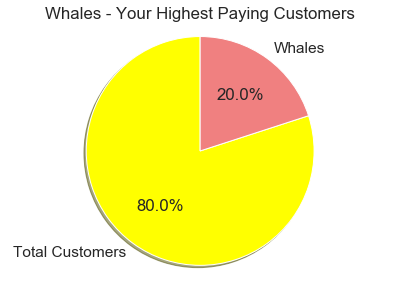

In [43]:
#RFM Code: XX1
print('Whales(Highest Paying Customers)-',len(rfm[(rfm['m_score']=='1')]))
labels = ['Total Customers','Whales']
sizes = [1590,398]
fig1, ax1 = plt.subplots()
colors = ['yellow', 'lightcoral']
explode = (0.1, 0, 0) 
ax1.pie(sizes,labels=labels,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Whales - Your Highest Paying Customers');

### 3. Promising - Faithful customers

In [44]:
# RFM Code: X13
print('Promising (Faithful customers)-',len(rfm[(rfm['f_score']=='1') & (rfm['m_score']=='3')])) 

Promising (Faithful customers)- 0


### 4.Rookies-Newest Customers

Rookies(Your Newest Customers)- 49


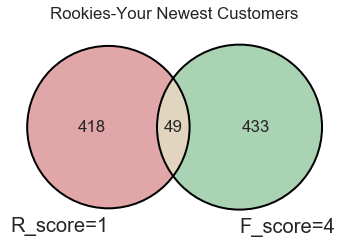

In [45]:
#RFM Code: 14X
# rscore1=418,fscore4=433
print('Rookies(Your Newest Customers)-',len(rfm[(rfm['r_score']=='1') & (rfm['f_score']=='4') ]))
venn2(subsets = (418,433,49), set_labels = ("R_score=1","F_score=4"), set_colors=('r', 'g'), alpha = 0.5);
venn2_circles(subsets = (418,433,49));
plt.title('Rookies-Your Newest Customers');

### 5.Slipping-Once Loyal, Now Gone

Slipping (Once Loyal,Now Gone)- 258


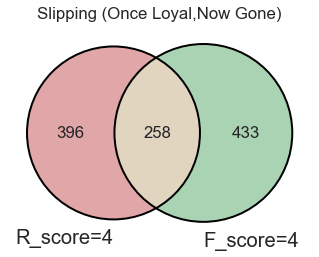

In [48]:
#RFM Code: 44X
print('Slipping (Once Loyal,Now Gone)-',len(rfm[(rfm['r_score']=='4') & (rfm['f_score']=='4') ]))
venn2(subsets = (396,433,258), set_labels = ("R_score=4","F_score=4"), set_colors=('r', 'g'), alpha = 0.5);
venn2_circles(subsets = (396,433,251));
plt.title('Slipping (Once Loyal,Now Gone)');

## End of notebook...